## 2_clean/station visualizations

The following notebook produces several key items related to all stations that have **cleaned** data:
- Updates the primary list of all stations with cleaned data, using station lists available for each network
    - Includes cleaned variable coverage for the primary stationlist csv
- Figure 1: station chart showing **actual** station temporal distribution
    - This figure represents information from the cleaned station lists, indicating actual station data availability (i.e., # of stations that are successfully cleaned)
    - This figure is an update from the `1_pull_stationvisualizer` notebook


In [1]:
# Import libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx

In [18]:
# Function: iterate through clean folder and get all station lists
def get_station_list_paths(bucket_name, directory):
    # Set up variables
    s3 = boto3.resource("s3")
    s3_cl = boto3.client('s3')
    get_last_modified = lambda obj: int(obj['LastModified'].strftime('%s')) #  Write method to get last modified file

    # Read in all station lists
    # Get list of folder prefixes
    response = s3_cl.list_objects_v2(Bucket=bucket_name, Prefix = directory, Delimiter = '/')

    networks = {'Network':[], 'NetworkPath':[], 'StationFile':[]}

    for prefix in response['CommonPrefixes']: # For each folder path
        networkpath = prefix['Prefix'][:-1]
        networkname = networkpath.split("/")[-1]
        station_file = s3.Bucket(bucket_name).objects.filter(Prefix = networkpath+"/"+"stationlist_").all()
        
        if len(list(station_file))==1: # If one item returned
            for item in station_file: # Get station file
                networks['Network'].append(networkname)
                networks['NetworkPath'].append(networkpath)
                networks['StationFile'].append(item.key)
                break # If more than one file of this format found in folder, just take the most recent
                
        elif len(list(station_file))==0: # If no items found using search above
            files = s3.Bucket(bucket_name).objects.filter(Prefix = networkpath+"/") # List all files in folder
            file = [file for file in files if "station" in file.key] # More general search for 'station'
            
            # Keep all files found here. These files may be different (e.g. ISD ASOS/AWOS vs ASOS/AWOS station lists)
            for item in file: 
                networks['Network'].append(networkname)
                networks['NetworkPath'].append(networkpath)
                networks['StationFile'].append(item.key)
                
        # If more than one identically formatted station list returned, take most recent
        elif len(list(station_file))>1: 
            
            # sort station lists by last edit
            file_all = [obj.key for obj in station_file]

            # need to handle for subsetted CWOP stationfiles
            if networkname == "CWOP":
                networks['Network'].append(networkname)
                networks['NetworkPath'].append(networkpath)
                networks['StationFile'].append(file_all[0]) # Add path to first in list -- alphabetical

            else:
                file = [obj.key for obj in sorted(station_file, key=lambda x: x.last_modified, reverse=True)]
                networks['Network'].append(networkname)
                networks['NetworkPath'].append(networkpath)
                networks['StationFile'].append(file[0]) # Add path to most recently changed file

    # Note: currently doesn't have a method for dealing with more than one normally formatted station file 
    return networks        

# -----------------------------------------------------------------------------------------------------------------

def get_station_list(bucket_name, directory):
    # Set up variables
    # Note these calls are reproduced in get_station_list_paths, but enables to run function separately
    s3 = boto3.resource("s3")
    s3_cl = boto3.client('s3') 
    dffull = pd.DataFrame()
    
    networks = get_station_list_paths(bucket_name, directory)
    networks = pd.DataFrame(networks)
    
    # Remove ASOS/AWOS merge version -- need to confirm what this is
    # If station has more than one type of station file (e.g. ASOSAWOS), manually remove the one you dont want to use
    remove_list = ['stationlist_ASOSAWOS_merge.csv']
    networks = networks[~networks.StationFile.str.contains('|'.join(remove_list))]

    # Check that no network has >1 station file and break code if it does.
    boolean = networks["Network"].is_unique

    total = 0 

    if boolean is False: # Tested by commenting out two remove lines above, works.
        dupes = networks['Network'].duplicated()
        doubles = list(networks['Network'][dupes])
        print("Error: More than one station file found for the following networks: {}. \
              Inspect folder, add duplicated files to remove_list and re-run function.".format(doubles))   
        return
    
    for index, row in networks.iterrows():
#         try:
        # Get data
        df = pd.DataFrame()
        obj = s3_cl.get_object(Bucket = bucket_name, Key = row['StationFile']) # get file
        body = obj['Body'].read()
        temp = pd.read_csv(BytesIO(body), encoding='utf8')   
        
        try:
            networkname = row['Network']

            print('Checking for cleaned stations: ', networkname)
            total += len(temp)
            
            # Deal with distinct formatting of different station lists.
            # Make column names to lower.
            temp.columns = temp.columns.str.lower()
            
            # Delete index column
            remove = [col for col in temp.columns if "unnamed" in col]
            if remove is not None:
                temp = temp.drop(remove, axis = 1)
                            
            
            # Each df should have at least the following columns:
                # ERA-ID: specific cleaned station name of network_station
                # LAT
                # LON
                # start-date: date station started running
                # end-date: date station stopped running
                # Cleaned: Y/N/NA, if station assessed as downloaded by stnlist_update_clean.py
                # Time_Cleaned: time of clean check
                
                # Cleaned variable coverage, number of valid observations
                # tas_nobs
                # tdps_nobs
                # tdps_derived_obs
                # ps_nobs
                # psl_nobs
                # ps_altimeter_nobs
                # ps_derived_nobs
                # pr_nobs
                # pr_5min_nobs
                # pr_1h_nobs
                # pr_25h_nobs
                # pr_localmid_nobs
                # hurs_nobs
                # sfcWind_nobs
                # sfcWind_dir_nobs
                # rsds_nobs
                # total_nobs: total length of data record, including nans
            
            # name: station name, station_name, name, dcp location name --> use name as filter
            if any('era-id' in str for str in temp.columns):
                colname = [col for col in temp.columns if "era-id" in col]
                df['era-id'] = temp[colname].values.reshape(-1, ) # Assign column to df.

            # latitude: lat or latitude
            if any('lat' in str for str in temp.columns):
                colname = [col for col in temp.columns if "lat" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])
                    colname = list(set(colname)-removelist)
                    if len(colname)>1:
                        print("Too many options for lat cols. Add manually to removelist: {}".format(colname))
                        break
                df['latitude'] = temp[colname].values.reshape(-1, )
            else:
                df['latitude'] = np.nan

            # longitude: lat or latitude
            if any('lon' in str for str in temp.columns):
                colname = [col for col in temp.columns if "lon" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])
                    colname = list(set(colname)-removelist)
                    if len(colname)>1:
                        print("Too many options for lon cols. Add manually to removelist: {}".format(colname))
                        break
                df['longitude'] = temp[colname].values.reshape(-1, )
            else:
                df['longitude'] = np.nan

            # elevation: elev or elevation (TO DO: convert to same unit!!)
            if any('elev' in str for str in temp.columns):
                colname = [col for col in temp.columns if "elev" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set(['elev(m)', 'barometer_elev', 'anemometer_elev']) # remove sensor heights
                    colname = list(set(colname)-removelist)
                    if len(colname)>1:
                        if 'elev_dem' in colname:
                            colname.remove("elev_dem")
                        if len(colname)>1:
                            print("Too many options for elev cols. Add manually to removelist: {}".format(colname))
                            break
                df['elevation'] = temp[colname].values.reshape(-1, )
            else:
                df['elevation'] = np.nan
            
            # start-date: search for start, begin or connect
            if any(y in x for x in temp.columns for y in ['begin', 'start', 'connect']):
                colname = [col for col in temp.columns if any(sub in col for sub in ['begin', 'start', 'connect'])]
                if len(colname)>1: # If more than one col returned
                    removelist = set(['startdate'])# Add any items to be manually removed here.
                    colname = list(set(colname)-removelist)
                    if len(colname)>1:
                        # If both start_time (parsed) and begin (not parsed) columns present, remove begin.
                        if 'start_time' in colname: 
                            if 'begin' in colname:
                                colname.remove("begin")
                        if 'disconnect' in colname:
                            colname.remove("disconnect")
                        if len(colname)>1:
                            print("Too many options for start cols. Add manually to removelist: {}".format(colname))
                            break
                df['start-date'] = temp[colname].values.reshape(-1, )
            else: # If no start date provided
                df['start-date'] = np.nan
            
            # end-date: search for end or disconnect
            if any(y in x for x in temp.columns for y in ['end', 'disconnect']):
                colname = [col for col in temp.columns if any(sub in col for sub in ['end', 'disconnect'])]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])# Add any items to be manually removed here.
                    colname = list(set(colname)-removelist)
                    if len(colname)>1:
                        # If both start_time (parsed) and begin (not parsed) columns present, remove begin.
                        if 'end_time' in colname: 
                            if 'end' in colname:
                                colname.remove("end")
                        if len(colname)>1:
                            print("Too many options for end cols. Add manually to removelist: {}".format(colname))
                            break
                df['end-date'] = temp[colname].values.reshape(-1, )
            else: # If no start date provided
                df['end-date'] = np.nan
                
                
            # Add pulled and date checked columns, if they exist
            if any('cleaned' in str for str in temp.columns):
                df['cleaned'] = temp['cleaned'].values.reshape(-1, )
            else:
                df['cleaned'] = np.nan

            if any('time_cleaned' in str for str in temp.columns):
                df['time_cleaned'] = temp['time_cleaned'].values.reshape(-1, )
            else:
                df['time_cleaned'] = np.nan

            # Make network column
            df['network'] = networkname
            
            ## Cleaned variable coverage
            cleaned_vars = ['tas_nobs', 'tdps_nobs', 'tdps_derived_nobs',
                           'ps_nobs', 'psl_nobs', 'ps_altimeter_nobs',
                           'pr_nobs', 'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs', 'pr_localmid_nobs',
                           'hurs_nobs', 'sfcwind_nobs', 'sfcwind_dir_nobs',
                           'rsds_nobs', 'total_nobs']
            
            for clean_var in cleaned_vars:
                if any(clean_var in str for str in temp.columns):
                    df[clean_var] = temp[clean_var].values.reshape(-1, )
                else:
                    df[clean_var] = np.nan # will be redundant once all networks have var coverage updated
            

            dffull = pd.concat([dffull, df], sort = False)

        except Exception as e:
            print(e)
            
            
    # Organize full dataframe
    # If end date is "active", make this be today's date.
    today = datetime.now()
    dffull['end-date'] = dffull['end-date'].replace('Active',today)

    # Format dates in datetime format.
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Drop empty rows - lat/lon as min criteria for inclusion
    dffull.dropna(subset=["latitude"], inplace=True)
    dffull.dropna(subset=["longitude"], inplace=True)
    
    # Remove any duplicates (of network and ID)
    dffull.sort_values(by=['start-date'], ascending = True, inplace = True) #  oldest network is always first
    dffull.drop_duplicates(subset = ['era-id', 'latitude', 'longitude', 'network'], inplace = True)
    
    # Print some useful statistics
    num_allstns = len(dffull)
    num_cleanstns = dffull['cleaned'].value_counts()['Y']
    print("Number of cleaned stations: ", num_cleanstns)
    print("Successful clean station rate: {}%".format((num_cleanstns / num_allstns)*100))
    
    # Resort by network
    dffull.sort_values(by=['network'], inplace = True)

    # Reset index.
    dffull = dffull.reset_index(drop = True)

    # Save station chart to AWS
    csv_buffer = StringIO()
    dffull.to_csv(csv_buffer, na_rep = "NaN")
    content = csv_buffer.getvalue()
    s3_cl.put_object(Bucket=bucket_name, Body=content, Key="2_clean_wx/temp_clean_all_station_list.csv")

    return dffull

# ------------------------------------------------------------------------------------------------------------------

# Function: plot station chart
# update = True, if you want to regenerate the primary (all) station list first
# update = False, function pulls the existing file from AWS
def get_station_chart(bucket_name, directory, update = False):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    
    if update == False:
        obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
        body = obj['Body'].read()
        dffull = pd.read_csv(BytesIO(body), encoding='utf8')
    elif update == True:
        dffull = get_station_list(bucket_name, directory)
    
    # Get period
    # Format dates in datetime format (this gets lost in import).
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Fix nas
    # Filter out rows w/o start date
    # Note here: we lose MARITIME and NDBC networks
    # print(dffull[dffull['network']=="MARITIME"])
    subdf = dffull.loc[~dffull['start-date'].isnull()].copy()

    # Filter out non-cleaned rows
    subdf = subdf.loc[subdf['cleaned']!="N"].copy()
    
    # Manually filter dates to >01-01-1980 and <today.
    # Timezones so far ignored here but we presume on the scale of month we can safely ignore them for the moment
    # Note!: This implicitly assumes stations w/o end date run until present 
    subdf['start-date'] = subdf['start-date'].apply(lambda x: x if x > datetime(1980,1,1, tzinfo=timezone.utc) 
                                                    else datetime(1980,1,1, tzinfo=timezone.utc))
    subdf['end-date'] = subdf['end-date'].apply(lambda x: x if x < datetime.utcnow().replace(tzinfo=timezone.utc) 
                                                else datetime.utcnow().replace(tzinfo=timezone.utc))
    
    # Get period of months for range of dates for each station
    subdf['period'] = [pd.period_range(*v, freq='M') for v in zip(subdf['start-date'], subdf['end-date'])]
    
    subdf = subdf[subdf.period.str.len()>0]
    subdf = subdf.reset_index(drop = True)

    out = subdf.explode('period').pivot_table(
        values = 'era-id', index = 'network', columns = 'period', aggfunc='count', fill_value=0)
    #out.columns = out.columns.strftime('%b-%y')
    
    return out

In [19]:
# generate station chart
bucket_name = "wecc-historical-wx"
directory = "2_clean_wx/"

station_list = get_station_list(bucket_name, directory) # Get combined station list
out = get_station_chart(bucket_name, directory, update = True) # set update=True to regenerate all stations list

Checking for cleaned stations:  ASOSAWOS
Checking for cleaned stations:  CAHYDRO
Checking for cleaned stations:  CDEC
Checking for cleaned stations:  CIMIS
Checking for cleaned stations:  CNRFC
Checking for cleaned stations:  CRN
Checking for cleaned stations:  CW3E
Checking for cleaned stations:  CWOP
Checking for cleaned stations:  HADS
Checking for cleaned stations:  HNXWFO
Checking for cleaned stations:  HOLFUY
Checking for cleaned stations:  HPWREN
Checking for cleaned stations:  LOXWFO
Checking for cleaned stations:  MAP
Checking for cleaned stations:  MARITIME
Checking for cleaned stations:  MTRWFO
Checking for cleaned stations:  NCAWOS
Checking for cleaned stations:  NDBC
Checking for cleaned stations:  NOS-NWLON
Checking for cleaned stations:  NOS-PORTS
Checking for cleaned stations:  OtherISD
Checking for cleaned stations:  RAWS
Checking for cleaned stations:  SCAN
Checking for cleaned stations:  SGXWFO
Checking for cleaned stations:  SHASAVAL
Checking for cleaned stations:  

## Figure: cleaned stations over time

s3.Object(bucket_name='wecc-historical-wx', key='2_clean_wx/clean_stations_over_time.png')

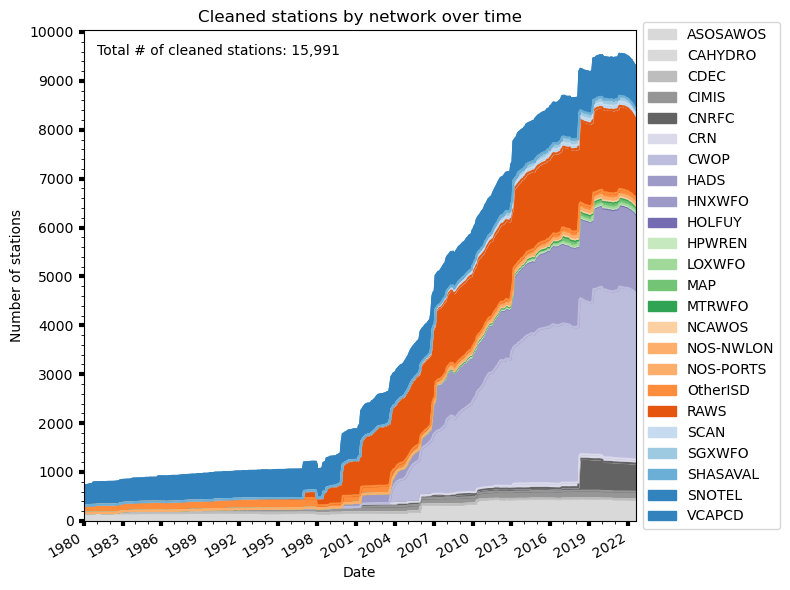

In [33]:
# Plot
outt = out.T.reset_index()

# Fix time component
outt['date'] = outt['period'].astype(str)
outt['date'] = pd.to_datetime(outt['date'])

# Plot parameters
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.facecolor'] = 'white'

# Subplot parameters
fig, ax = plt.subplots(figsize = (8, 6))
outt.plot.area(x='date', title='Cleaned stations by network over time', ax=ax, x_compat=True, cmap='tab20c_r')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Fix legend 
ax.tick_params(labelcolor='black', labelsize='medium', width=3)
ax.set_facecolor('w')
ax.set_xlabel("Date")
ax.set_ylabel("Number of stations")

# Change axis bounds
ax.set_xlim([date(1980, 1, 1), date(2022, 8, 1)])

# Change tick marks
ax.minorticks_on()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(3))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator(1))

# Change y ticks
plt.locator_params(axis='y', nbins=12)
ax.yaxis.get_ticklocs(minor=True)

# Set x axis labels
plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.8, right = 0.8)

# Annotate text for total number
# hard coding the number for now, come back to this
plt.annotate("Total # of cleaned stations: 15,991", xy=(0.025, 0.95), xycoords="axes fraction")

# Save to AWS
img_data = BytesIO()
plt.savefig(img_data, format='png')
img_data.seek(0)

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_stations_over_time.png")

#### Fig 2-3 Update from spatial maps of pulled data

/Users/victoriaford/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


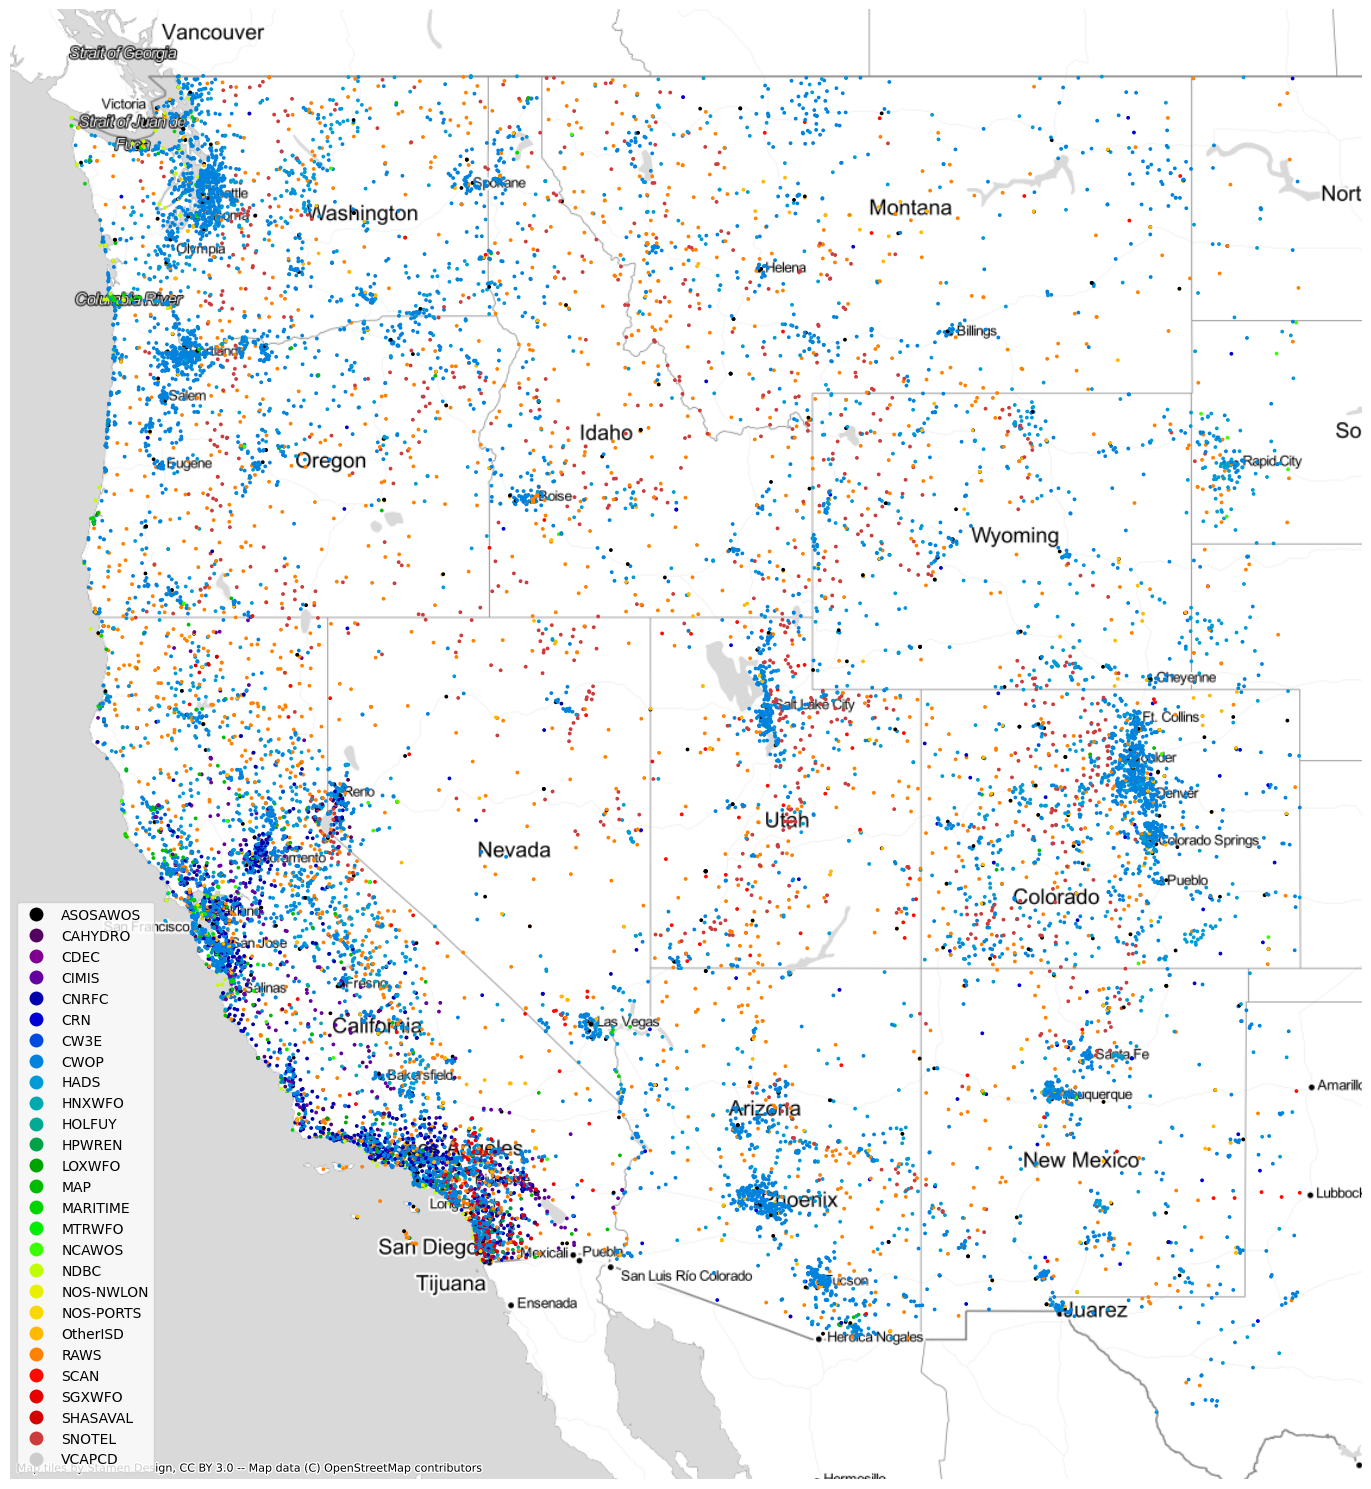

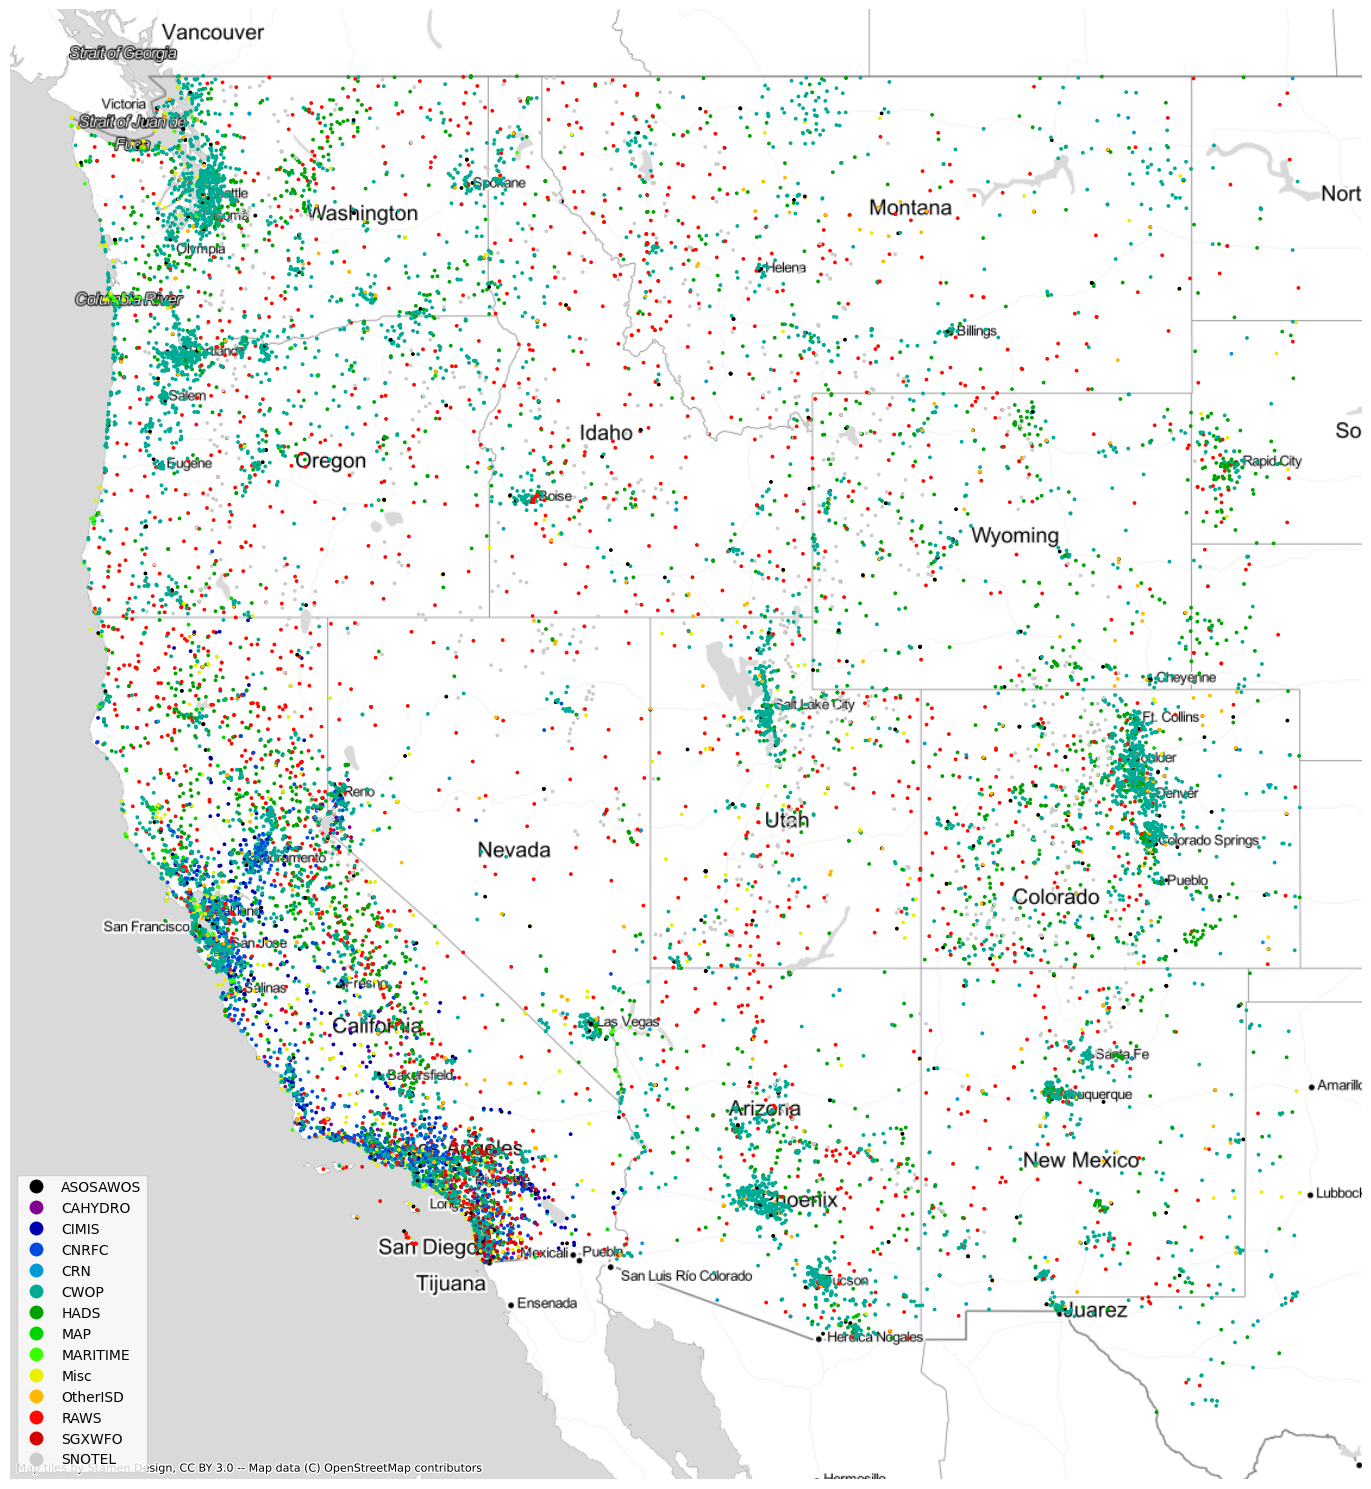

In [34]:
# Run function - generate station map
def get_station_map(bucket_name, directory, shapepath, update = False):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    if update == False:
        obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
        body = obj['Body'].read()
        dffull = pd.read_csv(BytesIO(body), encoding='utf8')
    elif update == True:
        dffull = get_station_list(bucket_name, directory)

    # Format dates in datetime format (this gets lost in import).
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # ------------------------------------------------------------------------------------------------------------
#     # Quality control (optional -- uncomment next 3 lines of code if desired)
#     # Filter out rows w/o start date - this will remove NDBC, MARITIME, CW3E networks (no date coverage in stn list)
#     subdf = dffull.loc[~dffull['start-date'].isnull()].copy()
#     # Filter out rows without data between 1980 and now.
#     subdf = subdf.loc[(subdf['start-date']<=datetime.utcnow().replace(tzinfo=timezone.utc)) 
#                       & (subdf['end-date']>='1980-01-01')]
    subdf = dffull
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe.
    gdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.longitude, subdf.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)

    # ------------------------------------------------------------------------------------------------------------
    # Version 1 - full map
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_map.png")


    # ------------------------------------------------------------------------------------------------------------
    # Version 2 - only big networks
    # Sort stations by number of networks
    gdf_us['network_count'] = gdf_us.groupby('network')['network'].transform('count') # Add network count column.

    # If <100 stations, change to "misc"
    gdf_us.loc[gdf_us['network_count'] < 100, 'network'] = "Misc"

    # Plot
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_map_min.png")
        
        
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
get_station_map(bucket_name, directory, shapepath = shapepath, update = False)

In [ ]:
# notes on cleaned variable figures

# cleaned primary station list with a Y/N column for every primary variable if each station has a valid value
# use start and end dates 

# fig 1
# grid of core vars with a dot if any record has a valid value (binary Y/N)

# fig 2
# modified version of fig 1, focusing on wind and solar --> renewables

# figs 3-X
# fig per variable, with decade of coverage
# 1980-89, 1990-99, 2000-09, 2010-19, 2020-2022

core_vars = ['tas', 'ps', 'tdps', 'hurs', 'pr', 'sfcWind', 'sfcWind_dir', 'rsds'] 
# maybe leave out 'pr' as it will be tricky
